In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torch import nn
import torch
import mylib
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
mylib.myprint("stuff")

iter 9: stuff


In [5]:
path = 'mnist/train.csv'
X, y = mylib.get_mnist_kaggle_in_2d_format(path, device, height=28, width=28, batch=42000)

In [6]:
X = torch.reshape(X, (42000,1,28,28))

In [7]:
# y = y[:1000]
# X = X[:1000]
X_test = X[:5000]
y_test = y[:5000]
X = X[5000:].to(device)
y = y[5000:].to(device)
X.shape

torch.Size([37000, 1, 28, 28])

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        print('-- init SimpleCNN --')
        
        self.sig = nn.Sigmoid()
        
        # input -> 28x28x1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        # output -> 24x24x64
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1, stride=2)
        
        self.fc1 = nn.Linear(in_features=3*3*128, out_features=10)
        
    def forward(self, X):
        out = self.sig(X)
        
        out = self.conv1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        
        # print(out.shape)
        out = torch.reshape(out, (out.shape[0], 3*3*128))

        out = self.fc1(out)
        
        return out

In [9]:
losses = []
accuracy = []

In [10]:
model = SimpleCNN().to(device)
loss_function = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

batch_size = 20

-- init SimpleCNN --


In [11]:
for epoch in range(10):
    running_loss = 0
    for i in range(int(y.shape[0]/batch_size)):
        optimizer.zero_grad()
        pred = model(X[batch_size*i:batch_size*i+batch_size])
        loss = loss_function(pred, y[batch_size*i:batch_size*i+batch_size])

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if(i % 100 == 0):
            losses.append((running_loss/9999))
            accuracy.append(mylib.mnist_score(model,X[:100],y[:100],dataset_size=100))
            running_loss = 0.0
            
        if(i % 1000 == 0):
            print(f'{epoch:2d} | {i:5d} | {loss.item():.3f}')

 0 |     0 | 0.118
 0 |  1000 | 0.021
 1 |     0 | 0.020
 1 |  1000 | 0.017
 2 |     0 | 0.017
 2 |  1000 | 0.016
 3 |     0 | 0.016
 3 |  1000 | 0.016
 4 |     0 | 0.016
 4 |  1000 | 0.015
 5 |     0 | 0.015
 5 |  1000 | 0.015
 6 |     0 | 0.015
 6 |  1000 | 0.014
 7 |     0 | 0.015
 7 |  1000 | 0.014
 8 |     0 | 0.016
 8 |  1000 | 0.014
 9 |     0 | 0.015
 9 |  1000 | 0.014


In [12]:
print('TRAIN: ', mylib.mnist_score(model, X[:37000], y[:37000], dataset_size=37000))

TRAIN:  98.17567567567568


In [13]:
print('TEST: ', mylib.mnist_score(model, X_test, y_test, dataset_size=5000))

TEST:  98.1


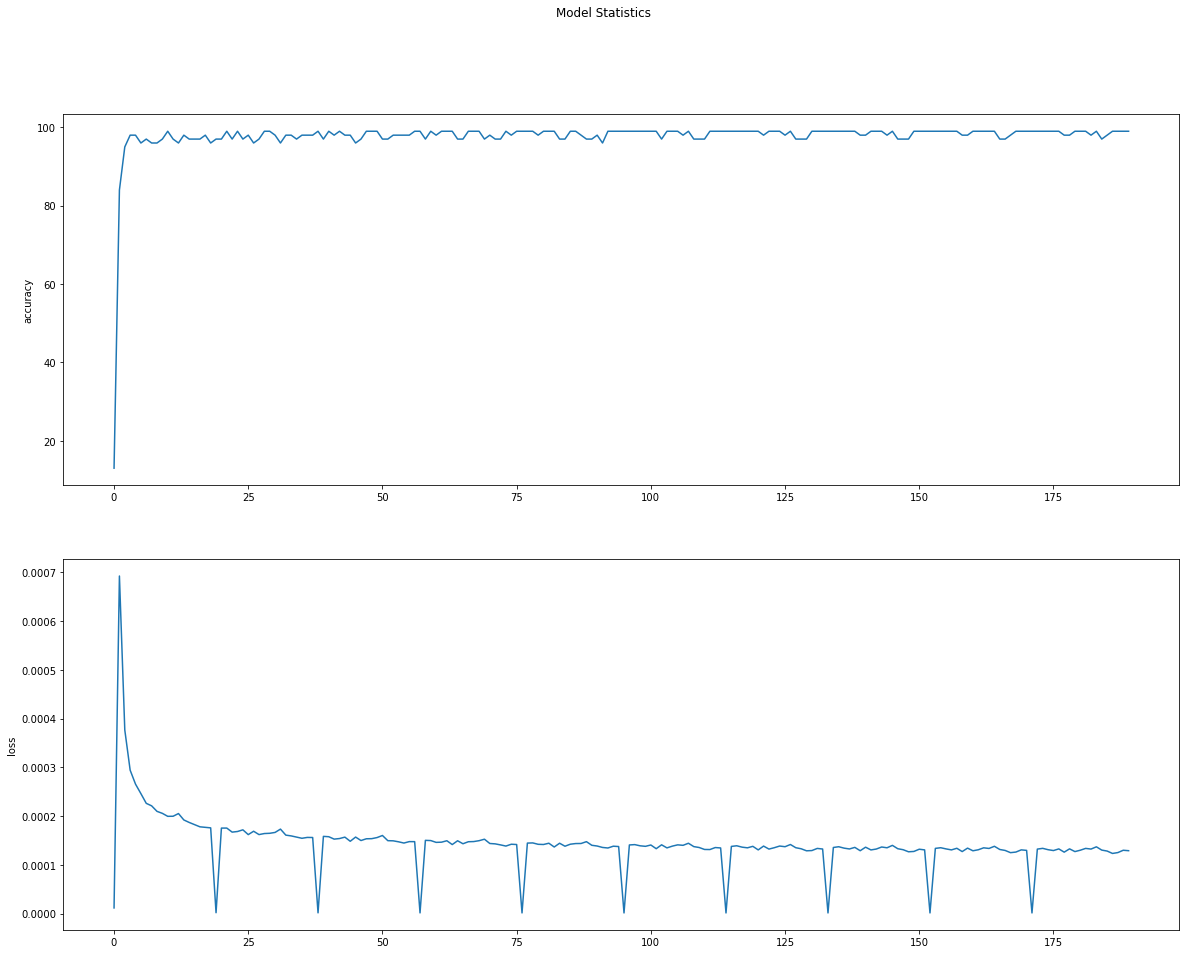

In [14]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()

In [15]:
torch.save(model.state_dict(), 'simplercnn.model')

In [43]:
model = SimpleCNN()
model.load_state_dict(torch.load('simplercnn.model'))
model = model.to(device)
model.eval()

-- init SimpleCNN --


SimpleCNN(
  (sig): Sigmoid()
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

In [16]:
path_to_test = 'mnist/test.csv'
path_to_sample = 'mnist/sample_submission.csv'
mylib.make_mnist_kaggle_submission(model, path_to_test, path_to_sample, device, 'auto_submission.csv')